<a href="https://colab.research.google.com/github/JoyeBright/Multilingual_Multimodal_Universal_MT/blob/main/NMT_S2S_Attention_Per_Eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hardware spec.**

In [1]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

## **Import headers**

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

import numpy as np
import unicodedata
import re
import io

In [3]:
!pip install hazm

In [4]:
from __future__ import unicode_literals
from hazm import *

## **Mount corpora**

In [5]:
file_path = '/content/drive/MyDrive/Multilingual_Multimodal_Unversal_MT/Parallel Corpora/Per-Eng/manythings/pes-eng/pes.txt'

## **Preprocessing**

In [6]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn') 

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip()) # lowercase
  w = re.sub(r"([?.!,¿])", r" \1 ", w) # creating a space between every word and punctuation
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w) # replacing every word with space except those defined

  w = w.strip() # remove space from beginning and end of string
  w = '<start> '+ w + ' <end>' # later model needs this to know where to start and stop

  return w

def preprocess_per_sentence(w):
  normalizer = Normalizer() # Persian normalizer instance (Hazm)
  normalizer.normalize(w)
  w = unicode_to_ascii(w.lower().strip()) # lowercase
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = '<start> '+ w + ' <end>'

  return w


## **An example**

In [7]:
eng_sentence = "You have beautiful hands."
per_sentence ="تو دستهای زیبایی داری."


print(preprocess_sentence(eng_sentence))
print(preprocess_per_sentence(per_sentence))

<start> you have beautiful hands . <end>
<start> تو دستهای زیبایی داری .  <end>


## **Create a dataset (word pair) from corpus**

In [8]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding="UTF-8").read().strip().split('\n')
  word_pairs = [[preprocess_per_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs) # zip used for parallel iteration

In [9]:
en, per, info = create_dataset(file_path, None) # info is an explanation which included in the corpus

In [10]:
print(en[-3])
print(per[-3])
print(info[-3])

<start> the difference between the right word and almost the right word is the difference between lightning and the lightning bug .  <end>
<start> تفاوت بین کلمه صحیح و کلمه تقریبا صحیح مانند تفاوت بین مهتاب و کرم شب‌تاب است .  <end>
<start> cc-by 2 . 0 (france) attribution: tatoeba . org #667975 (ck) & #7525272 (cojiluc) <end>


In [11]:
def tokenize(lang):
  language_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
  
  # Creating the vocabulary index based on word frequency.
  # 0 is a reserved index that won't be assigned to any word
  language_tokenizer.fit_on_texts(lang) 

  # Transforming each text in texts to a sequence of integers
  tensor = language_tokenizer.texts_to_sequences(lang) 

  # pads the sequences to the same length.
  # seq = [[1], [2, 3], [4, 5, 6]]
  # post-padding
  # array([[1, 0, 0],
  #          [2, 3, 0],
  #          [4, 5, 6]])
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  
  return tensor, language_tokenizer

In [12]:
def load_dataset(path, number_examples = None):
  target_language, source_language, info = create_dataset(path, number_examples)

  source_tensor, source_lang_tokenize = tokenize(source_language)
  target_tensor, target_lang_tokenize = tokenize(target_language)

  return source_tensor, target_tensor, source_lang_tokenize, target_lang_tokenize, info

**Limit/ control the size of dataset to experiment faster**

In [13]:
number_examples = 2200 # var
source_tensor, target_tensor, source_lang, target_lang, info = load_dataset(file_path, number_examples)


In [14]:
# Calculating max_length of the source and target tensors
max_length_target, max_length_source = target_tensor.shape[1], source_tensor.shape[1]

# Using sklearn to creat training and validation sets: 80-20 split
source_tensor_train, source_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size = 0.2)

In [15]:
# Print info up to here
print(" training size of source (Per): ", len(source_tensor_train),"\n", "training size of target (Eng): ", len(target_tensor_train), "\n", "validation size of source (Per): ", len(source_tensor_val), "\n", "validation size of target (Eng): ", len(target_tensor_val))

 training size of source (Per):  1760 
 training size of target (Eng):  1760 
 validation size of source (Per):  440 
 validation size of target (Eng):  440


### **Finding the word from their indices or vice versa (word-index dictionary)**

In [16]:
def convert(language, tensor):
  for t in tensor:
    if t!=0:
      print("%d ––––––> %s" % (t, language.index_word[t]))

In [17]:
print("mapping source language: index to word")
convert(source_lang, source_tensor_train[0])
print("")
print("mapping target language: index to word")
convert(target_lang, target_tensor_train[0])

mapping source language: index to word
1 ––––––> <start>
1192 ––––––> نمایشگاه
25 ––––––> برای
14 ––––––> یک
376 ––––––> ماه
97 ––––––> دیگر
142 ––––––> باز
314 ––––––> خواهند
364 ––––––> ماند
3 ––––––> .
2 ––––––> <end>

mapping target language: index to word
1 ––––––> <start>
4 ––––––> the
968 ––––––> exhibition
40 ––––––> will
165 ––––––> stay
290 ––––––> open
23 ––––––> for
532 ––––––> another
537 ––––––> month
3 ––––––> .
2 ––––––> <end>


## **Dataset preparation for Tensorflow**


In [18]:
#Hyperparameters
BATCH_SIZE = 64
step_per_epoch = len(source_tensor_train) // BATCH_SIZE
embedding_dimension = 256
units = 1024
BUFFER_SIZE = len(source_tensor_train)
vocabulary_source_size = len(source_lang.word_index) + 1
vocabulary_target_size = len(target_lang.word_index) + 1

print("Persian vocabulary size: ", vocabulary_source_size)
print("English vocabulary size: ", vocabulary_target_size)

Persian vocabulary size:  3533
English vocabulary size:  2438


In [19]:
# Keras models accept three types of inputs: Numpy array, TF dataset objects(sth I used here), and Python generators
dataset = tf.data.Dataset.from_tensor_slices((source_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# drop_remainder ignores the last batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

### **An example**

In [20]:
example_source_batch, example_target_batch = next(iter(dataset))
example_source_batch.shape, example_target_batch.shape

(TensorShape([64, 19]), TensorShape([64, 19]))

## **Designing encoder and decoder model with attention**

## **Encoder**
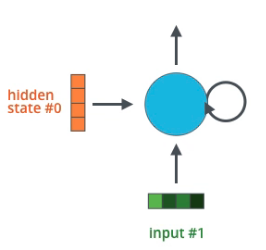

In [21]:
# ENCODER:
# Embedding layer (1)
# GRU layer (2)
# First hidden layer shape is: [batch_size, number of neurons]
# Second or output layer shape is: [batch_size, max_length, number of neurons]
#..................................................................
class Encoder(tf.keras.Model):
  def __init__(self, vocabulary_size, embedding_dimension, encoder_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.encoder_units = encoder_units
    self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension)
    self.gru = tf.keras.layers.GRU(self.encoder_units, 
                                              return_sequences=True,
                                              return_state=True,
                                              recurrent_initializer='glorot_uniform') # default: orthogonal
  
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state
  

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.encoder_units))

In [22]:
encoder = Encoder(vocabulary_source_size, embedding_dimension, units, BATCH_SIZE)

### **An example of encoder**

In [23]:
# Sample
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_source_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 19, 1024)
Encoder hidden state shape: (batch size, units) (64, 1024)
